In [1]:
from astroquery.gaia import Gaia
from astroquery.esasky import ESASky
import numpy as np
from simbad_download import resolve_name
import pandas as pd
import pyvo as vo
import gaia_download as gd
from cross_match import add_panstarrs1, add_twomass
import matplotlib.pyplot as plt
from extinction import add_color, mag_abs, add_colors_and_abs_mag

Configuration file not found:

    /home/mjablons/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


1. arcesonds

GALEX cross-match: 3 arcseconds, even 5

In [2]:
sources = pd.read_csv('./found_cp_tails.csv')

In [3]:
gaia_data = gd.gaia_download_data(sources.source_id.values)

Executing Gaia query for 1050 sources...
Executing query...
INFO: Query finished. [astroquery.utils.tap.core]
Query finished!


In [4]:
sources_dr3 = pd.merge(left=gaia_data, right=sources[['source_id', 'TIC']], on='source_id', how='left')

In [5]:
sources_dr3.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,TIC
0,1636148068921376768,Gaia DR3 573545534662757504,573545534662757504,843580694,2016.0,10.732846,0.238209,84.682801,0.235746,0.523439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1636148068921376768,Gaia DR3 573549009293487360,573549009293487360,117320301,2016.0,9.938466,0.017343,84.833263,0.015769,0.509673,...,0.3516,0.3785,0.3000,0.2862,0.3085,0.1604,0.1530,0.1649,PHOENIX,461598969.0
2,1636148068921376768,Gaia DR3 573549932709068416,573549932709068416,349334707,2016.0,12.411280,0.060851,84.778756,0.051277,0.479208,...,0.3281,0.4416,0.2968,0.2580,0.3485,0.1590,0.1382,0.1865,PHOENIX,NaN
3,1636148068921376768,Gaia DR3 573552475329793152,573552475329793152,1255013827,2016.0,12.264538,0.048599,84.907228,0.039843,0.532028,...,0.0679,0.1218,0.0764,0.0541,0.0973,0.0405,0.0287,0.0516,PHOENIX,461618421.0
4,1636148068921376768,Gaia DR3 573552651425754240,573552651425754240,1610097616,2016.0,11.786204,0.056529,84.867786,0.051901,0.572127,...,0.2256,0.2827,0.2018,0.1771,0.2226,0.1062,0.0932,0.1172,PHOENIX,NaN


In [6]:
sources_dr3 = add_colors_and_abs_mag(sources_dr3)

In [7]:
sources_with_panstarrs = add_panstarrs1(sources_dr3)

INFO: Query finished. [astroquery.utils.tap.core]
panstarrs1 cross-match: 998 sources


In [8]:
sources_with_panstarrs = add_color(sources_with_panstarrs, 'g', 'r')
sources_with_panstarrs = mag_abs(sources_with_panstarrs, 'g')

In [9]:
sources_with_panstarrs = sources_with_panstarrs[np.abs(sources_with_panstarrs['g-r'])<10]
sources_with_panstarrs = sources_with_panstarrs[np.abs(sources_with_panstarrs['g_abs'])<30]

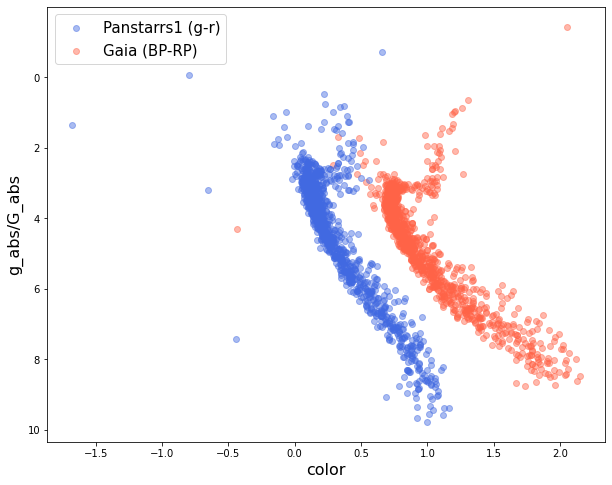

In [10]:
plt.figure(figsize=(10, 8))
plt.scatter(sources_with_panstarrs['g-r'], sources_with_panstarrs.g_abs,
            color='royalblue', label='Panstarrs1 (g-r)', alpha=.45, zorder=2)
plt.scatter(sources_with_panstarrs['BP-RP'], sources_with_panstarrs['G_abs'],
            color='tomato', label='Gaia (BP-RP)', alpha=.45)
plt.gca().invert_yaxis();
plt.legend(fontsize=15);
plt.gca().set_ylabel('g_abs/G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);

In [11]:
sources_all = add_twomass(sources_with_panstarrs)

INFO: Query finished. [astroquery.utils.tap.core]
tmass_psc_xsc cross-match: 919 sources
INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [12]:
%matplotlib notebook  

In [13]:
from sklearn.ensemble import IsolationForest

In [14]:
color_mag_abs = sources_all[['BP-RP', 'G_abs']]

In [15]:
clf = IsolationForest(contamination=0.25).fit_predict(color_mag_abs.values)

In [16]:
sources_all['outlier'] = clf

<IPython.core.display.Javascript object>


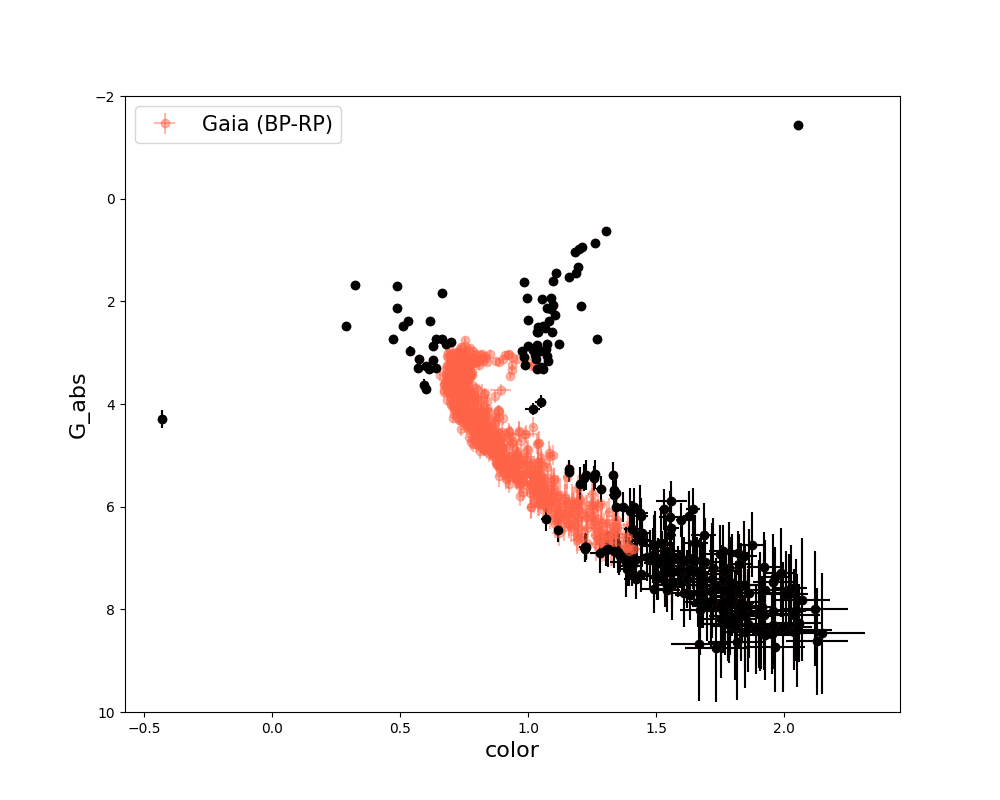

In [17]:
plt.figure(figsize=(10, 8))
plt.errorbar(sources_all['BP-RP'], sources_all['G_abs'],
             xerr=sources_all['BP-RP_error'], yerr=sources_all['G_abs_error'],
             color='tomato', label='Gaia (BP-RP)', alpha=.45, fmt='o')
plt.errorbar(sources_all[sources_all.outlier==-1]['BP-RP'], sources_all[sources_all.outlier==-1]['G_abs'],
             xerr=sources_all[sources_all.outlier==-1]['BP-RP_error'],
             yerr=sources_all[sources_all.outlier==-1]['G_abs_error'],
            color='black', fmt='o', zorder=2);
plt.gca().invert_yaxis();
plt.legend(fontsize=15);
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.gca().set_ylim(10, -2);


In [18]:
isochrone = np.loadtxt('./cmd_test.dat', usecols=(28, 29, 30))

In [19]:
isochrone.shape

(297, 3)

In [20]:
isochrone = isochrone[isochrone[:, 1]<25]

<IPython.core.display.Javascript object>


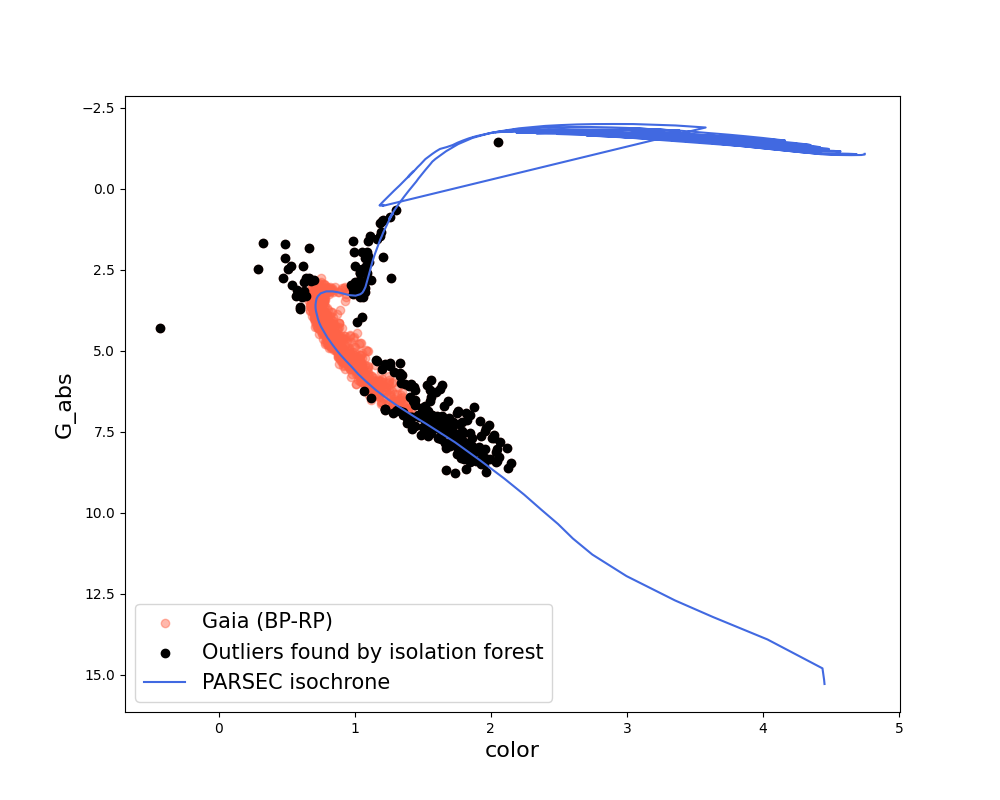

In [21]:
plt.figure(figsize=(10, 8))
plt.scatter(sources_all['BP-RP'], sources_all['G_abs'],
            color='tomato', label='Gaia (BP-RP)', alpha=.45)
plt.scatter(sources_all[sources_all.outlier==-1]['BP-RP'], sources_all[sources_all.outlier==-1]['G_abs'],
            color='black', label='Outliers found by isolation forest')
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.plot(isochrone[:, 1]-isochrone[:, 2], isochrone[:, 0], label='PARSEC isochrone', color='royalblue')
plt.gca().invert_yaxis();
plt.legend(fontsize=15);

Constrain the isochrone to the part that interests me

<IPython.core.display.Javascript object>


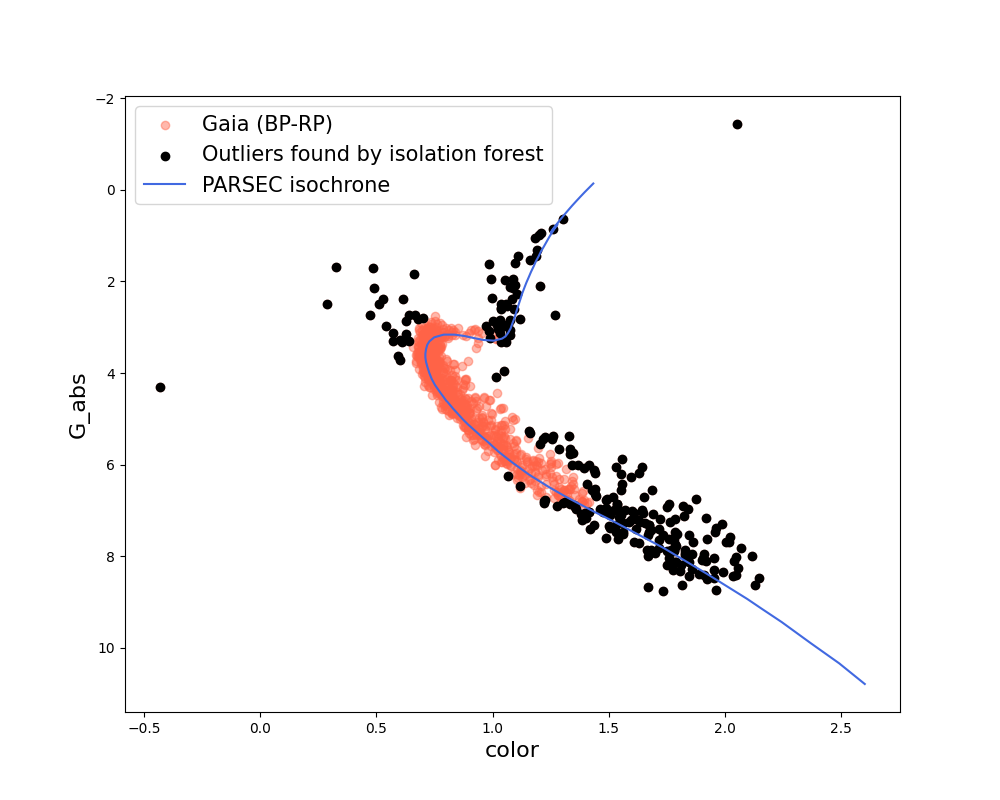

In [22]:
plt.figure(figsize=(10, 8))

isochrone_start_ind = 10
isochrone_end_ind = 100

plt.scatter(sources_all['BP-RP'], sources_all['G_abs'],
            color='tomato', label='Gaia (BP-RP)', alpha=.45)
plt.scatter(sources_all[sources_all.outlier==-1]['BP-RP'], sources_all[sources_all.outlier==-1]['G_abs'],
            color='black', label='Outliers found by isolation forest')
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.plot(isochrone[isochrone_start_ind:isochrone_end_ind, 1]-isochrone[isochrone_start_ind:isochrone_end_ind, 2],
         isochrone[isochrone_start_ind:isochrone_end_ind, 0], label='PARSEC isochrone', color='royalblue')
plt.gca().invert_yaxis();
plt.legend(fontsize=15);

In [23]:
isochrone_cut = isochrone[isochrone_start_ind:isochrone_end_ind]
isochrone_cut = np.concatenate([
    (isochrone_cut[:, 1]-isochrone_cut[:, 2]).reshape(-1, 1),
    isochrone_cut[:, 0].reshape(-1, 1)], axis=1)

In [24]:
from scipy.interpolate import interp1d

In [25]:
BOUNDS = np.max(isochrone_cut, axis=0)-np.min(isochrone_cut, axis=0)

In [26]:
BOUNDS

array([ 1.892, 10.926])

In [27]:
def closest(source, isochrone):
    two_closest = isochrone[
    np.argsort(
            np.linalg.norm((source-isochrone), axis=1).flatten()
        )
    ][:2]
    return two_closest[0], two_closest[1]

def distance_to_closest(source, isochrone):
    src_rescaled = source/BOUNDS
    isochrone_rescaled = isochrone/BOUNDS
    p1, p2 = closest(src_rescaled, isochrone_rescaled)
    return np.linalg.norm(np.cross((p2-p1), (p1-src_rescaled)))/np.linalg.norm((p2-p1))

def above_isochrone(source, isochrone, verbose=False):
    p1, p2 = closest(source, isochrone)
    if verbose:
        print('Closest points:', p1, p2)
    point = interp1d([p1[0], p2[0]], [p1[1], p2[1]], fill_value='extrapolate')(source[0])
    if verbose:
        print(point)
    return source[1] <= point

In [28]:
dists = np.apply_along_axis(
    lambda x: distance_to_closest(x, isochrone_cut), 1,
    sources_all[['BP-RP', 'G_abs']].values)

In [29]:
above_equal_binary_limit = np.apply_along_axis(
    lambda x: above_isochrone(x, isochrone_cut+np.array([0., -0.75])), 1,
    sources_all[['BP-RP', 'G_abs']].values)

<IPython.core.display.Javascript object>


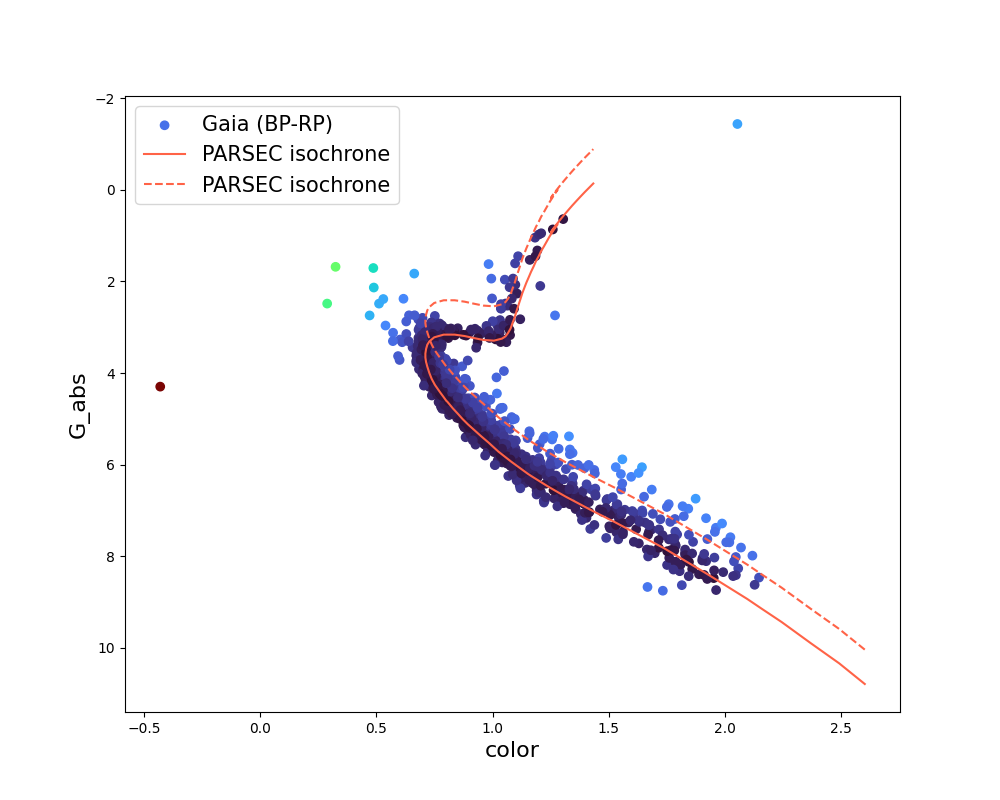

In [30]:
fig = plt.figure(figsize=(10, 8));
plt.scatter(sources_all['BP-RP'], sources_all['G_abs'],
            c=dists, cmap='turbo', label='Gaia (BP-RP)')
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.plot(isochrone_cut[:, 0], isochrone_cut[:, 1], label='PARSEC isochrone', color='tomato')
plt.plot(isochrone_cut[:, 0], isochrone_cut[:, 1]-0.75, label='PARSEC isochrone', color='tomato', linestyle='--')
plt.gca().invert_yaxis();
plt.legend(fontsize=15);

In [31]:
np.std(dists)

0.032050708383792446

<IPython.core.display.Javascript object>


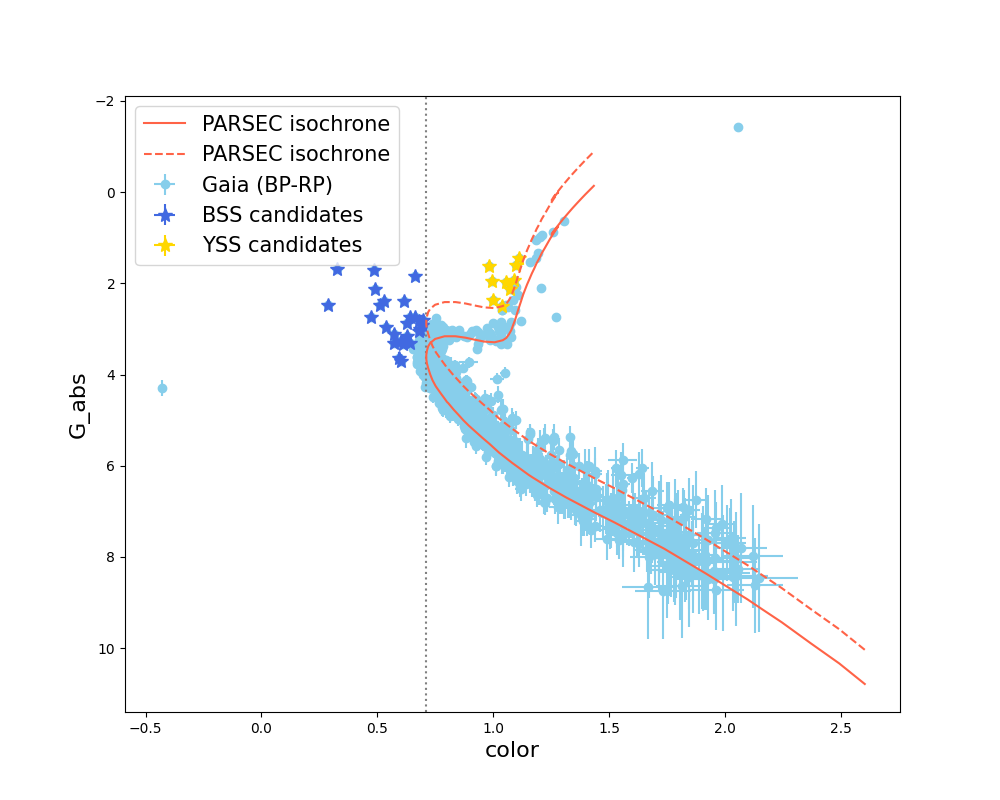

In [32]:
plt.figure(figsize=(10, 8));

TO_COLOR = np.min(isochrone_cut[:, 0])

plt.errorbar(sources_all['BP-RP'], sources_all['G_abs'],
             xerr=sources_all['BP-RP_error'], yerr=sources_all['G_abs_error'],
             color='skyblue', label='Gaia (BP-RP)', fmt='o', zorder=1)
plt.gca().set_ylabel('G_abs', fontsize=16);
plt.gca().set_xlabel('color', fontsize=16);
plt.plot(isochrone_cut[:, 0], isochrone_cut[:, 1], label='PARSEC isochrone', color='tomato', zorder=3)
plt.plot(isochrone_cut[:, 0], isochrone_cut[:, 1]-0.75, label='PARSEC isochrone', color='tomato', zorder=3, linestyle='--')
bss_candidates = sources_all[((dists>=np.std(dists)) & (sources_all['BP-RP']<TO_COLOR) & (sources_all['BP-RP']>0))]
yss_candidates = sources_all[(sources_all['BP-RP']>TO_COLOR) & (sources_all['G_abs']<2.5) & (sources_all['BP-RP']<2.) &
                             ((above_equal_binary_limit) | (dists>=np.std(dists)))]
plt.errorbar(bss_candidates['BP-RP'], bss_candidates['G_abs'],
             xerr=bss_candidates['BP-RP_error'], yerr=bss_candidates['G_abs_error'],
             color='royalblue', fmt='*', zorder=2, label='BSS candidates', markersize=10.)
plt.errorbar(yss_candidates['BP-RP'], yss_candidates['G_abs'],
             xerr=yss_candidates['BP-RP_error'], yerr=yss_candidates['G_abs_error'],
             color='gold', fmt='*', zorder=2, label='YSS candidates', markersize=10.)
plt.axvline(x=TO_COLOR, color='gray', linestyle='dotted')
plt.gca().invert_yaxis();
plt.legend(fontsize=15);

In [33]:
len(bss_candidates)

26

In [34]:
len(yss_candidates)

9

In [58]:
bss_candidates.to_csv('./bss_candidates.csv', index=None)
yss_candidates.to_csv('./yss_candidates.csv', index=None)

# Download Gaia photometry if any

In [59]:
from astroquery.gaia import Gaia

In [60]:
retrieval_type = 'ALL'          # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'INDIVIDUAL'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
data_release   = 'Gaia DR3'     # Options are: 'Gaia DR3' (default), 'Gaia DR2'


datalink = Gaia.load_data(ids=bss_candidates['source_id'],
                          data_release = data_release,
                          retrieval_type= 'EPOCH_PHOTOMETRY',
                          data_structure = data_structure,
                          verbose = False, output_file = None)
dl_keys  = [inp for inp in datalink.keys()]
dl_keys.sort()

print()
print(f'The following Datalink products have been downloaded:')
for dl_key in dl_keys:
    print(f' * {dl_key}')



The following Datalink products have been downloaded:
 * EPOCH_PHOTOMETRY-Gaia DR3 573944283722429952.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 573968576057423360.xml


In [37]:
dl_out = datalink['EPOCH_PHOTOMETRY-Gaia DR3 573944283722429952.xml'][0].to_table().to_pandas()

In [38]:
dl_out

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
0,573944283722429952,16794188979904685,G,1700.557556,15.022556,18446.934900,26.344404,700.222107,False,False,1,375316653866487564
1,573944283722429952,16798281267345192,G,1700.631566,14.997984,18869.177234,33.508351,563.118652,False,False,1,375316653866487564
2,573944283722429952,21033056143447168,G,1777.217809,14.983139,19128.956926,78.108717,244.901688,False,False,1021,375316653866487564
3,573944283722429952,22024321596408398,G,1795.144777,14.987913,19045.023858,15.632087,1218.328979,False,False,4194305,375316653866487564
4,573944283722429952,25274103025144796,G,1853.914651,14.986382,19071.906511,12.391667,1539.091309,False,False,1,375316653866487564
...,...,...,...,...,...,...,...,...,...,...,...,...
114,573944283722429952,63680499056657168,RP,2548.475958,14.508677,12464.859361,60.054832,207.557968,False,False,0,375316653866487564
115,573944283722429952,65792953363350052,RP,2586.677775,14.539376,12117.353064,54.227367,223.454575,False,False,0,375316653866487564
116,573944283722429952,65797045646958874,RP,2586.751778,14.494048,12633.941525,57.734010,218.830139,False,False,0,375316653866487564
117,573944283722429952,68946433283854891,RP,2643.704574,14.505618,12500.026490,56.504357,221.222351,False,False,0,375316653866487564


<IPython.core.display.Javascript object>


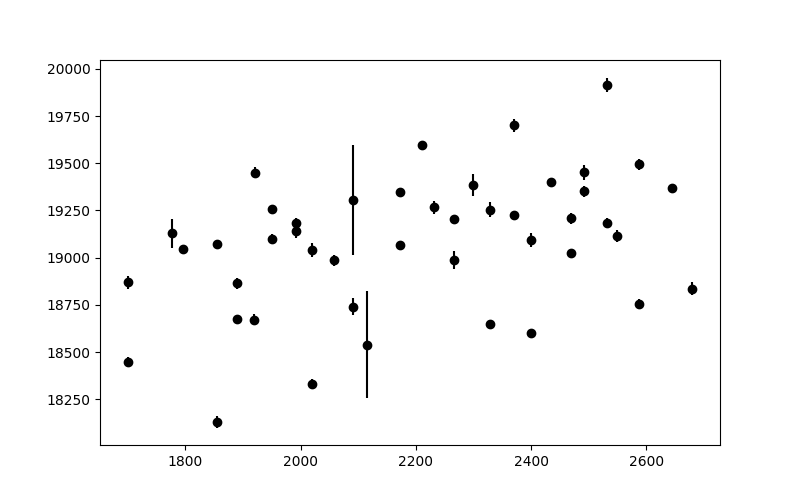

In [57]:
plt.figure(figsize=(8, 5));

g_mag = dl_out[dl_out['band']=='G']
rp_mag = dl_out[dl_out['band']=='RP']
bp_mag = dl_out[dl_out['band']=='BP']

plt.errorbar(g_mag.time, g_mag.flux, yerr=g_mag.flux_error, c='black', fmt='o');
# plt.plot(rp_mag.time, rp_mag.mag, c='indianred');
# plt.plot(bp_mag.time, bp_mag.mag, c='royalblue');
# plt.gca().invert_yaxis();

In [186]:
photo2 = datalink['EPOCH_PHOTOMETRY-Gaia DR3 573968576057423360.xml'][0].to_table().to_pandas()

In [47]:
bss_candidates[bss_candidates.source_id==573944283722429952].TIC

729    461599358.0
Name: TIC, dtype: float64

In [39]:
from lightkurve import search_lightcurve

To check: de-trending in lightkurve?

1. Clean TESS ligthcurves
2. Periodograms

In [55]:
search_lightcurve(target='TIC 461599358', mission='TESS')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 18,2019,CDIPS,1800,461599358,0.0
1,TESS Sector 18,2019,PATHOS,1800,461599358,0.0
2,TESS Sector 20,2019,CDIPS,1800,461599358,0.0
3,TESS Sector 20,2019,PATHOS,1800,461599358,0.0
4,TESS Sector 25,2020,CDIPS,1800,461599358,0.0
5,TESS Sector 25,2020,PATHOS,1800,461599358,0.0
6,TESS Sector 26,2020,CDIPS,1800,461599358,0.0
7,TESS Sector 26,2020,PATHOS,1800,461599358,0.0


In [50]:
lc = search_lightcurve(target='TIC 461599358', mission='TESS').download_all()

TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]

<IPython.core.display.Javascript object>


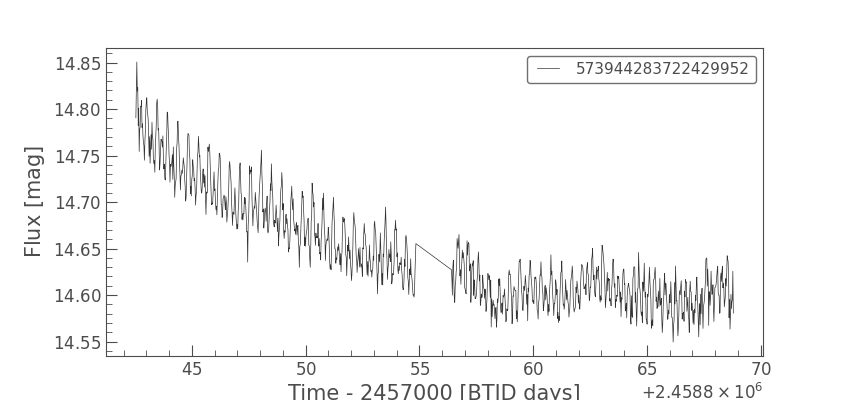

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{mag}$]'>

In [53]:
lc[2].plot()

In [210]:
[int(i) for i in bss_candidates.panstarrs1_id.values]

[209780139283378880,
 210190125233618880,
 210220123665889088,
 210250122272603040,
 210260120834059840,
 210310131083600128,
 210290125455103520,
 210300122644109216,
 210330124041933792,
 210240114877718560,
 210230112475697664,
 210270117991921312,
 210290117249573184,
 210300119648693856,
 210260111699553856,
 210260109234056576,
 210330105278576576,
 210330118060374112,
 210340115962815296,
 210350114865500704,
 210390110990344832,
 210410108496721696,
 210410124451261312,
 210530110892500864,
 210640136315263936,
 210370066859952832]

In [219]:
query = '''
SELECT
                  objID, detectID, Detection.filterID as filterID, Filter.filterType, obsTime, ra, dec,
                  psfFlux, psfFluxErr, psfMajorFWHM, psfMinorFWHM, psfQfPerfect, 
                  apFlux, apFluxErr, infoFlag, infoFlag2, infoFlag3
              FROM Detection
              NATURAL JOIN Filter
              WHERE objID=210330118060374112
              ORDER BY filterID, obsTime
'''

https://ps1images.stsci.edu/ps1_dr2_api.html

In [220]:
import pyvo as vo

PANSTARRS1 = vo.dal.TAPService("http://vao.stsci.edu/PS1DR2/tapservice.aspx")

In [221]:
result = PANSTARRS1.run_async(query)

In [222]:
result

<Table length=0>
objID detectID filterid filterType ... apFluxErr infoFlag infoFlag2 infoFlag3
                                   ...                                       
int64  int64    uint8     object   ...  float32   int64     int32     int32  
----- -------- -------- ---------- ... --------- -------- --------- ---------